# Training a neural network to classify images of MFCCs

## Load dataset

In [1]:

import os

current_dir = os.getcwd()
directory = os.path.dirname(current_dir) + "/datasets/"
csv_files_train = [directory + "/train/" + f for f in os.listdir(directory + "train/") if f.endswith('.csv')]
csv_files_validation = [directory + "/validation/" + f for f in os.listdir(directory + "validation/") if f.endswith('.csv')]

print("training files: ", len(csv_files_train))
print("validation files: ", len(csv_files_validation))


training files:  3300
validation files:  900


Test import of csv datasets into tensorflow datasets

import every csv file as a single matrix with one label associated

In [2]:
# imports of necessary libraries

import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available and being used
print(tf.config.list_physical_devices('GPU'))

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


2023-08-23 12:53:24.554521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 12:53:33.007488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-23 12:53:42.412193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 12:53:45.074111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 12:53:45.074779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:

# create training and validation datasets
dataset_train = []
dataset_validation = []
labels_train = []
labels_validation = []

# read csv files into lists
# the label (language) is written in the file name

for file in csv_files_train:
    data_array = np.genfromtxt(file, delimiter=',', dtype=np.int8)
    dataset_train.append(data_array)
    
    file_name = os.path.basename(file)
    labels_train.append(file_name[5:8])

for file in csv_files_validation:
    data_array = np.genfromtxt(file, delimiter=',', dtype=np.int8)
    dataset_validation.append(data_array)

    file_name = os.path.basename(file)
    labels_validation.append(file_name[5:8])

print("dataset train size: ", len(dataset_train))
print("dataset validation size: ", len(dataset_validation))
print("labels train size: ", len(labels_train))
print("labels validation size: ", len(labels_validation))

dataset train size:  3300
dataset validation size:  900
labels train size:  3300
labels validation size:  900


In [4]:
# print size of one element of the dataset: feature size
mfcc_size = dataset_train[0].shape
print ("mfcc_size: ", mfcc_size)

mfcc_size:  (349, 12)


In [5]:
classes = ["ita", "eng", "fra"]

# Create a mapping from class names to integer labels
class_to_index = {class_name: index for index, class_name in enumerate(classes)}
print(class_to_index)

# Convert labels to integer labels using the mapping
integer_labels_train = np.array([class_to_index[label] for label in labels_train], dtype=np.int8)
integer_labels_validation = np.array([class_to_index[label] for label in labels_validation], dtype=np.int8)

y_onehot_train = tf.keras.utils.to_categorical(integer_labels_train, num_classes = len(classes)) # one hot encoding
y_onehot_validation = tf.keras.utils.to_categorical(integer_labels_validation, num_classes = len(classes)) # one hot encoding



{'ita': 0, 'eng': 1, 'fra': 2}


In [6]:

x_train = tf.reshape(dataset_train, (-1, mfcc_size[0], mfcc_size[1], 1))
x_validation = tf.reshape(dataset_validation, (-1, mfcc_size[0], mfcc_size[1], 1))

print("Training features shape:", x_train.shape)
print("Validation features shape:", x_validation.shape)

# create tensorflow dataset from numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_onehot_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_validation, y_onehot_validation))


2023-08-23 12:54:03.431654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 12:54:03.432195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 12:54:03.432534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Training features shape: (3300, 349, 12, 1)
Validation features shape: (900, 349, 12, 1)


In [7]:
batch_size = 64
num_epochs = 150
mfcc_shape = (mfcc_size[0], mfcc_size[1], 1)

# shuffle and batch
train_dataset = train_dataset.shuffle(len(x_train))
#val_dataset = val_dataset.shuffle(len(x_validation))

# apply batching to the datasets
val_dataset = val_dataset.batch(batch_size)
train_dataset = train_dataset.batch(batch_size)

In [8]:
for image_batch, labels_batch in train_dataset:
	print("MFCC batch input feature shape: ", image_batch.shape)
	print("MFCC labels shape: ", labels_batch.shape)
	break

MFCC batch input feature shape:  (64, 349, 12, 1)
MFCC labels shape:  (64, 3)


## Models training and evaluation

In [9]:
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping


#### Model 1

In [51]:

# first model version

# Create a basic CNN model
model = models.Sequential([
	layers.Conv2D(filters=16, kernel_size=(5, 1), activation='relu', input_shape=mfcc_shape),
	layers.MaxPooling2D(pool_size=(2, 1)),
    layers.Conv2D(filters=16, kernel_size=(1, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 1)),
    layers.Conv2D(filters=16, kernel_size=(5, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.GlobalAveragePooling2D(),
	layers.AveragePooling2D(pool_size=(41, 3)),
	layers.Flatten(),
	#layers.Dense(32, activation='relu'),
    #layers.Dense(32, activation='relu'),
	layers.Dense(len(classes), activation='softmax')  # as many classes as languages
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 345, 12, 16)       96        
                                                                 
 max_pooling2d (MaxPooling2  (None, 172, 12, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 8, 16)        1296      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 86, 8, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 82, 6, 16)         3856      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 41, 3, 16)         0

In [52]:

# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(),
			  loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for one-hot encoded labels
			  metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1, restore_best_weights=True)

callbacks_list = [early_stopping]

# Train the model
model.fit(x=train_dataset, epochs=num_epochs, callbacks=callbacks_list, validation_data=val_dataset)



Epoch 1/150


52/52 [==============================] - 3s 19ms/step - loss: 2.1630 - accuracy: 0.3882 - val_loss: 1.1148 - val_accuracy: 0.4167
Epoch 2/150
52/52 [==============================] - 1s 13ms/step - loss: 1.0857 - accuracy: 0.4436 - val_loss: 1.2440 - val_accuracy: 0.3744
Epoch 3/150
52/52 [==============================] - 1s 14ms/step - loss: 1.0092 - accuracy: 0.4933 - val_loss: 0.9657 - val_accuracy: 0.5589
Epoch 4/150
52/52 [==============================] - 1s 14ms/step - loss: 0.9306 - accuracy: 0.5542 - val_loss: 0.9089 - val_accuracy: 0.5589
Epoch 5/150
52/52 [==============================] - 1s 14ms/step - loss: 0.9058 - accuracy: 0.5706 - val_loss: 0.8987 - val_accuracy: 0.5844
Epoch 6/150
52/52 [==============================] - 1s 13ms/step - loss: 0.8555 - accuracy: 0.6061 - val_loss: 0.8482 - val_accuracy: 0.6322
Epoch 7/150
52/52 [==============================] - 1s 13ms/step - loss: 0.8544 - accuracy: 0.6091 - val_loss: 0.8193 - val_accuracy: 0.6356
Epoch 8/150
52/52 

In [53]:
# evaluate model on test set

evaluation = model.evaluate(val_dataset, batch_size=32)
evaluation = dict(zip(model.metrics_names, evaluation))
print(evaluation)

 1/15 [=>............................] - ETA: 0s - loss: 0.3329 - accuracy: 0.8281

15/15 [==============================] - 0s 6ms/step - loss: 0.4641 - accuracy: 0.8233
{'loss': 0.46408218145370483, 'accuracy': 0.8233333230018616}


#### Model 2: more parameters and different types of conv layers

In [32]:
'''
# create new CNN model
input_layer = tf.keras.layers.Input(shape=mfcc_shape, name='input_layer')
conv1 = tf.keras.layers.Conv2D(16, (5, 1), activation='relu', padding='same', name='conv1')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D((2, 1), name='pool1')(conv1)
conv2 = tf.keras.layers.Conv2D(16, (1, 5), activation='relu', padding='same', name='conv2')(pool1)
pool2 = tf.keras.layers.MaxPooling2D((2, 1), name='pool2')(conv2)
conv3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='conv3')(pool2)
pool3 = tf.keras.layers.MaxPooling2D((2, 2), name='pool3')(conv3)
avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(21, 2), name='avg_pool')(pool3)
flatten = tf.keras.layers.Flatten(name='flatten')(avg_pool)
dense1 = tf.keras.layers.Dense(64, activation='relu', name='dense1', kernel_regularizer='l2')(flatten)
dropout = tf.keras.layers.Dropout(0.3, name='dropout')(dense1)
dense2 = tf.keras.layers.Dense(32, activation='relu', name='dense2', kernel_regularizer='l2')(dropout)
output_layer = tf.keras.layers.Dense(len(classes), activation='softmax', name='output_layer')(dense2)
'''

input_layer = tf.keras.layers.Input(shape=mfcc_shape, name='input_layer')
conv1 = tf.keras.layers.Conv2D(16, (5, 1), activation='relu', padding='valid', name='conv1')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D((2, 1), name='pool1')(conv1)
conv2 = tf.keras.layers.Conv2D(16, (1, 5), activation='relu', padding='valid', name='conv2')(pool1)
pool2 = tf.keras.layers.MaxPooling2D((2, 1), name='pool2')(conv2)
avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(40, 1), name='avg_pool')(pool2)
flatten = tf.keras.layers.Flatten(name='flatten')(avg_pool)

dropout = tf.keras.layers.Dropout(0.3, name='dropout')(flatten)

dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer='l2')(dropout)
dense2 = tf.keras.layers.Dense(32, activation='relu', name='dense2', kernel_regularizer='l2')(dense1)
output_layer = tf.keras.layers.Dense(len(classes), activation='softmax', name='output_layer')(dense2)

model_2 = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model_2.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 349, 12, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 345, 12, 16)       96        
                                                                 
 pool1 (MaxPooling2D)        (None, 172, 12, 16)       0         
                                                                 
 conv2 (Conv2D)              (None, 172, 8, 16)        1296      
                                                                 
 pool2 (MaxPooling2D)        (None, 86, 8, 16)         0         
                                                                 
 avg_pool (AveragePooling2D  (None, 2, 8, 16)          0         
 )                                                               
                                                           

In [33]:

# prints learning rate during training
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

# learning rate scheduler with polynomial decay
learning_rate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.0004,
    decay_steps=10000,
    end_learning_rate=2.5e-4,
    power=0.3
)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
lr_metric = get_lr_metric(optimizer)


In [34]:
# Compile the model 2
model_2.compile(optimizer = optimizer,
			  loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for one-hot encoded labels
			  metrics=['accuracy', lr_metric])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1, restore_best_weights=True)

callbacks_list = [early_stopping]

# Train the model
model_2.fit(x=train_dataset, epochs=num_epochs, callbacks=callbacks_list, validation_data=val_dataset)

Epoch 1/150


52/52 [==============================] - 3s 15ms/step - loss: 3.5460 - accuracy: 0.3427 - lr: 3.9989e-04 - val_loss: 2.1296 - val_accuracy: 0.3133 - val_lr: 3.9977e-04
Epoch 2/150
52/52 [==============================] - 1s 12ms/step - loss: 2.1760 - accuracy: 0.3530 - lr: 3.9965e-04 - val_loss: 1.9517 - val_accuracy: 0.3744 - val_lr: 3.9953e-04
Epoch 3/150
52/52 [==============================] - 1s 13ms/step - loss: 2.0147 - accuracy: 0.3588 - lr: 3.9941e-04 - val_loss: 1.9232 - val_accuracy: 0.3722 - val_lr: 3.9930e-04
Epoch 4/150
52/52 [==============================] - 1s 13ms/step - loss: 1.9582 - accuracy: 0.3455 - lr: 3.9918e-04 - val_loss: 1.8921 - val_accuracy: 0.4056 - val_lr: 3.9906e-04
Epoch 5/150
52/52 [==============================] - 1s 12ms/step - loss: 1.9075 - accuracy: 0.3867 - lr: 3.9894e-04 - val_loss: 1.8698 - val_accuracy: 0.3811 - val_lr: 3.9882e-04
Epoch 6/150
52/52 [==============================] - 1s 12ms/step - loss: 1.8722 - accuracy: 0.3836 - lr: 3.9870

In [35]:
evaluation_2 = model_2.evaluate(val_dataset, batch_size=32)
evaluation_2 = dict(zip(model_2.metrics_names, evaluation_2))
print(evaluation_2)


# print model_3's confusion matrix
model_2_pred = model_2.predict(val_dataset)
model_2_pred = np.argmax(model_2_pred, axis=1)

model_2_true = np.concatenate([y for x, y in val_dataset], axis=0)
model_2_true = np.argmax(model_2_true, axis=1)
model_2_cm = confusion_matrix(model_2_true, model_2_pred, labels=[0, 1, 2])
# normalize the cm to have sum 1 on each row
model_2_cm = model_2_cm.astype('float') / model_2_cm.sum(axis=1)[:, np.newaxis]

print(model_2_cm)

 1/15 [=>............................] - ETA: 0s - loss: 0.4512 - accuracy: 0.8438 - lr: 3.4525e-04

15/15 [==============================] - 0s 6ms/step - loss: 0.4801 - accuracy: 0.8533 - lr: 3.4525e-04
{'loss': 0.4800722897052765, 'accuracy': 0.8533333539962769, 'lr': 0.000345252628903836}
15/15 [==============================] - 0s 5ms/step
[[0.79333333 0.09666667 0.11      ]
 [0.13       0.79333333 0.07666667]
 [0.01666667 0.01       0.97333333]]


#### Model 3: with residual connections

In [224]:
# create CNN with residual connections
input_layer = tf.keras.layers.Input(shape=mfcc_shape, name='input_layer')

conv1 = tf.keras.layers.Conv2D(16, (5, 1), activation='relu', padding='same', name='conv1')(input_layer)
conv11 = tf.keras.layers.Conv2D(16, (1, 1), activation='relu', padding='same', name='conv11')(input_layer)
add1 = tf.keras.layers.Add(name='add1')([input_layer, conv1])
pool1 = tf.keras.layers.MaxPooling2D((2, 1), name='pool1')(add1)

conv2 = tf.keras.layers.Conv2D(16, (1, 5), activation='relu', padding='same', name='conv2')(pool1)
conv22 = tf.keras.layers.Conv2D(16, (1, 1), activation='relu', padding='same', name='conv22')(pool1)
add2 = tf.keras.layers.Add(name='add2')([pool1, conv2])
pool2 = tf.keras.layers.MaxPooling2D((2, 1), name='pool2')(add2)

conv3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='conv3')(pool2)
conv33 = tf.keras.layers.Conv2D(16, (1, 1), activation='relu', padding='same', name='conv33')(pool2)
add3 = tf.keras.layers.Add(name='add3')([conv33, conv3])
pool3 = tf.keras.layers.MaxPooling2D((2, 1), name='pool3')(add3)

avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(21, 2), name='avg_pool')(add3)
flatten = tf.keras.layers.Flatten(name='flatten')(avg_pool)

# dropout = tf.keras.layers.Dropout(0.3, name='dropout')(flatten)
dense1 = tf.keras.layers.Dense(64, activation='relu', name='dense1', kernel_regularizer='l2')(flatten)
dense2 = tf.keras.layers.Dense(32, activation='relu', name='dense2', kernel_regularizer='l2')(dense1)
output_layer = tf.keras.layers.Dense(len(classes), activation='softmax', name='output_layer')(dense2)


model_3 = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model_3.summary()

Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 349, 12, 1)]         0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 349, 12, 16)          96        ['input_layer[0][0]']         
                                                                                                  
 add1 (Add)                  (None, 349, 12, 16)          0         ['input_layer[0][0]',         
                                                                     'conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 174, 12, 16)          0         ['add1[0][0]']         

In [222]:
# prints learning rate during training
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

# learning rate scheduler with polynomial decay
learning_rate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.0008,
    decay_steps=10000,
    end_learning_rate=5e-4,
    power=0.3
)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
lr_metric = get_lr_metric(optimizer)


In [223]:
# Compile the model 3
model_3.compile(optimizer = optimizer,
			  loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for one-hot encoded labels
			  metrics=['accuracy', lr_metric])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1, restore_best_weights=True)

callbacks_list = [early_stopping]

# Train the model
model_3.fit(x=train_dataset, epochs=num_epochs, callbacks=callbacks_list, validation_data=val_dataset)

Epoch 1/150
52/52 [==============================] - 3s 20ms/step - loss: 12.1498 - accuracy: 0.3552 - lr: 7.9977e-04 - val_loss: 4.1026 - val_accuracy: 0.3633 - val_lr: 7.9954e-04
Epoch 2/150
52/52 [==============================] - 1s 16ms/step - loss: 3.3232 - accuracy: 0.3973 - lr: 7.9930e-04 - val_loss: 3.2925 - val_accuracy: 0.3733 - val_lr: 7.9907e-04
Epoch 3/150
52/52 [==============================] - 1s 16ms/step - loss: 2.8681 - accuracy: 0.4064 - lr: 7.9883e-04 - val_loss: 2.8614 - val_accuracy: 0.3944 - val_lr: 7.9860e-04
Epoch 4/150
52/52 [==============================] - 1s 16ms/step - loss: 2.5523 - accuracy: 0.4227 - lr: 7.9836e-04 - val_loss: 2.5529 - val_accuracy: 0.4489 - val_lr: 7.9812e-04
Epoch 5/150
52/52 [==============================] - 1s 16ms/step - loss: 2.4767 - accuracy: 0.4552 - lr: 7.9788e-04 - val_loss: 2.4830 - val_accuracy: 0.4600 - val_lr: 7.9765e-04
Epoch 6/150
52/52 [==============================] - 1s 16ms/step - loss: 2.3291 - accuracy: 0.4742

In [216]:
evaluation_3 = model_3.evaluate(val_dataset, batch_size=64)
evaluation_3 = dict(zip(model_3.metrics_names, evaluation_3))
print(evaluation_3)


# print model_3's confusion matrix
model_3_pred = model_3.predict(val_dataset)
model_3_pred = np.argmax(model_3_pred, axis=1)

model_3_true = np.concatenate([y for x, y in val_dataset], axis=0)
model_3_true = np.argmax(model_3_true, axis=1)
model_3_cm = confusion_matrix(model_3_true, model_3_pred, labels=[0, 1, 2])
# normalize the cm to have sum 1 on each row
model_3_cm = model_3_cm.astype('float') / model_3_cm.sum(axis=1)[:, np.newaxis]

print(model_3_cm)


 1/15 [=>............................] - ETA: 0s - loss: 0.7499 - accuracy: 0.7969 - lr: 6.3469e-04

15/15 [==============================] - 0s 9ms/step - loss: 0.7339 - accuracy: 0.7844 - lr: 6.3469e-04
{'loss': 0.7338971495628357, 'accuracy': 0.7844444513320923, 'lr': 0.0006346917361952364}
15/15 [==============================] - 0s 6ms/step
[[0.79333333 0.15666667 0.05      ]
 [0.22569444 0.69444444 0.07986111]
 [0.06410256 0.07692308 0.85897436]]


### Save model for evaluation and testing

In [36]:
parent_dir = os.path.dirname(os.getcwd())
filepath = parent_dir + "/model_lite/"
model_2.save(filepath +  "CNN_model")

INFO:tensorflow:Assets written to: /home/simon/Spoken_Language_Recognition_Tensorflow_Embedded/model_lite/CNN_model/assets


INFO:tensorflow:Assets written to: /home/simon/Spoken_Language_Recognition_Tensorflow_Embedded/model_lite/CNN_model/assets


## Model Conversion to Tensorflow Lite

In [37]:
parent_dir = os.path.dirname(os.getcwd())
filepath = parent_dir + "/model_lite/"
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(filepath + "CNN_model")
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,  # enable TensorFlow Lite ops.
    #tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]

converter.experimental_enable_resource_variables = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset(num_samples = x_train.shape[0]):
    for x, y in train_dataset.take(num_samples):
    	yield [tf.cast(x, dtype=tf.float32)]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset

tflite_model = converter.convert()

# write the converted model into a file
with open(filepath + "CNN_model.tflite", 'wb') as f:
	f.write(tflite_model)

2023-08-23 13:06:54.313180: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-23 13:06:54.313224: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-23 13:06:54.313415: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /home/simon/Spoken_Language_Recognition_Tensorflow_Embedded/model_lite/CNN_model
2023-08-23 13:06:54.315303: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-08-23 13:06:54.315410: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /home/simon/Spoken_Language_Recognition_Tensorflow_Embedded/model_lite/CNN_model
2023-08-23 13:06:54.324242: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-23 13:06:54.400769: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /home/simon/Spoken_Language_R

In [38]:
model_path = filepath + "CNN_model.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([  1, 349,  12,   1], dtype=int32), 'shape_signature': array([ -1, 349,  12,   1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, 0), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 21, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [39]:
# Assuming single input and output tensors.
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

print(input_shape)
print(output_shape)

[  1 349  12   1]
[1 3]


Convert the TFLite model into a TFMicro model using the bash script below 

In [50]:
!xxd -i ./../model_lite/CNN_model.tflite > ./../model_lite/model_tflite_data.cc

/bin/bash: /home/simon/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Evaluate quantized model on test sets

In [40]:

def tflite_model_evaluation(x_test, y_onehot_test):

	# convert test set into int8
	x_test_int8 = tf.convert_to_tensor(tf.cast(x_test, tf.int8))
	y_test_int8 = tf.convert_to_tensor(tf.cast(y_onehot_test, tf.int8))
	# Convert the random data point from int8 to float32
	batch_size = len(x_test_int8)

	eval_shape = (1, mfcc_size[0], mfcc_size[1], 1)
	print("x shape = ", x_test_int8.shape)
	print("y shape =", y_test_int8.shape)

	predictions = np.empty( (y_test_int8.shape) )

	for i in range(batch_size):
		# Set input data to the interpreter.
		interpreter.set_tensor(input_details[0]['index'], tf.reshape(x_test_int8[i], eval_shape) )

		# Run inference.
		interpreter.invoke()

		# Get output data from the interpreter.
		output_data = interpreter.get_tensor(output_details[0]['index'])

		# get quantization parameters from output_details
		output_scale, output_zero_point = output_details[0]['quantization']

		# scale and zero point dequantization to get probabilities
		output_probability = tf.math.softmax(output_data / output_scale + output_zero_point)
		predictions[i] = output_probability.numpy()

	mse_loss = np.sqrt( np.sum( (y_test_int8 - predictions)**2 ) ) / batch_size
	accuracy = np.sum( np.argmax(predictions, axis=1) == np.argmax(y_test_int8, axis=1) ) / batch_size
	print("Accuracy in test set of quantized TFLite model: {:.4f}".format(accuracy))
	print("MSE loss in test set of quantized TFLite model: {:.4f}".format(mse_loss))

	# print model's confusion matrix
	predictions_class = np.argmax(predictions, axis=1)
	true_labels = np.argmax(y_test_int8, axis=1)
	cm = confusion_matrix(true_labels, predictions_class, labels=[0, 1, 2])
	# normalize the cm to have sum 1 on each row
	cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

	print(cm)

	# Plot the confusion matrix
	plt.imshow(cm, interpolation='nearest', cmap='viridis')
	plt.title('Confusion matrix')
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes)
	plt.yticks(tick_marks, classes)
	plt.xlabel('Predicted label')
	plt.ylabel('True label')
	plt.show()

x shape =  (900, 349, 12, 1)
y shape = (900, 3)
Accuracy in test set of quantized TFLite model: 0.8533
MSE loss in test set of quantized TFLite model: 0.0181
[[0.79333333 0.09666667 0.11      ]
 [0.12666667 0.79333333 0.08      ]
 [0.01666667 0.01       0.97333333]]


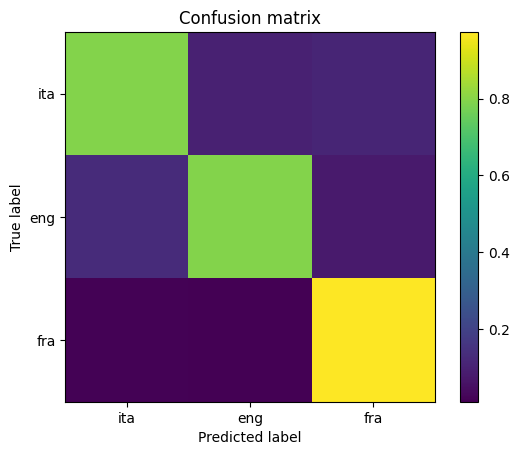

In [41]:
# evaluate validation set with post training quantized model
tflite_model_evaluation(x_test = x_validation, y_onehot_test = y_onehot_validation)


### Load test sets

In [42]:

import os

current_dir = os.getcwd()
directory = os.path.dirname(current_dir) + "/datasets/"
csv_files_unheard = [directory + "/test_unheard_speakers/" + f for f in os.listdir(directory + "test_unheard_speakers/") if f.endswith('.csv')]
csv_files_known = [directory + "/test_known_speakers/" + f for f in os.listdir(directory + "test_known_speakers/") if f.endswith('.csv')]

print("test_unheard_speakers files: ", len(csv_files_unheard))
print("test_known_speakers files: ", len(csv_files_known))

test_unheard_speakers files:  1260
test_known_speakers files:  1170


In [43]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available and being used
print(tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [44]:
import numpy as np

# create training and validation datasets
dataset_test_known = []
dataset_test_unheard = []
labels_test_known = []
labels_test_unheard = []

# read csv files into lists
# the label (language) is written in the file name

for file in csv_files_known:
    data_array = np.genfromtxt(file, delimiter=',', dtype=np.int8)
    dataset_test_known.append(data_array)
    
    file_name = os.path.basename(file)
    labels_test_known.append(file_name[5:8])

for file in csv_files_unheard:
    data_array = np.genfromtxt(file, delimiter=',', dtype=np.int8)
    dataset_test_unheard.append(data_array)

    file_name = os.path.basename(file)
    labels_test_unheard.append(file_name[5:8])

print("dataset_test_known size: ", len(dataset_test_known))
print("dataset_test_unheard size: ", len(dataset_test_unheard))
print("labels_test_known size: ", len(labels_test_known))
print("labels_test_unheard size: ", len(labels_test_unheard))

dataset_test_known size:  1170
dataset_test_unheard size:  1260
labels_test_known size:  1170
labels_test_unheard size:  1260


In [45]:
# print size of one element of the dataset: feature size
mfcc_size = dataset_test_known[0].shape
print ("mfcc_size: ", mfcc_size)

mfcc_size:  (349, 12)


In [46]:
classes = ["ita", "eng", "fra"]

# Create a mapping from class names to integer labels
class_to_index = {class_name: index for index, class_name in enumerate(classes)}
print(class_to_index)

# Convert labels to integer labels using the mapping
integer_labels_test_unheard = np.array([class_to_index[label] for label in labels_test_unheard], dtype=np.int8)
integer_labels_test_known = np.array([class_to_index[label] for label in labels_test_known], dtype=np.int8)

y_onehot_test_unheard = tf.keras.utils.to_categorical(integer_labels_test_unheard, num_classes = len(classes)) # one hot encoding
y_onehot_test_known = tf.keras.utils.to_categorical(integer_labels_test_known, num_classes = len(classes)) # one hot encoding



{'ita': 0, 'eng': 1, 'fra': 2}


In [47]:

x_test_unheard = tf.reshape(dataset_test_unheard, (-1, mfcc_size[0], mfcc_size[1], 1))
x_test_known = tf.reshape(dataset_test_known, (-1, mfcc_size[0], mfcc_size[1], 1))

print("unheard speakers features shape:", x_test_unheard.shape)
print("known speakers with noisy audio features shape:", x_test_known.shape)

# create tensorflow dataset from numpy arrays
test_unheard_dataset = tf.data.Dataset.from_tensor_slices((x_test_unheard, y_onehot_test_unheard))
test_known_dataset = tf.data.Dataset.from_tensor_slices((x_test_known, y_onehot_test_known))


unheard speakers features shape: (1260, 349, 12, 1)
known speakers with noisy audio features shape: (1170, 349, 12, 1)


### Evaluate Test sets

In [48]:
parent_dir = os.path.dirname(os.getcwd())
filepath = parent_dir + "/model_lite/"

model_path = filepath + "CNN_model.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([  1, 349,  12,   1], dtype=int32), 'shape_signature': array([ -1, 349,  12,   1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, 0), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 21, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


evaluating accuracy of quantized model on test set: unheard speakers
x shape =  (1260, 349, 12, 1)
y shape = (1260, 3)


Accuracy in test set of quantized TFLite model: 0.6429
MSE loss in test set of quantized TFLite model: 0.0237
[[0.62619048 0.30714286 0.06666667]
 [0.23571429 0.58809524 0.17619048]
 [0.18571429 0.1        0.71428571]]


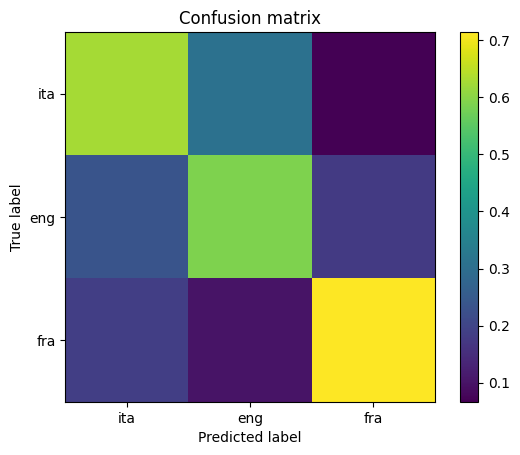


evaluating accuracy of quantized model on test set: known speakers with noisy audio recordings
x shape =  (1170, 349, 12, 1)
y shape = (1170, 3)
Accuracy in test set of quantized TFLite model: 0.7752
MSE loss in test set of quantized TFLite model: 0.0198
[[0.7025641  0.10769231 0.18974359]
 [0.14615385 0.71538462 0.13846154]
 [0.06923077 0.02307692 0.90769231]]


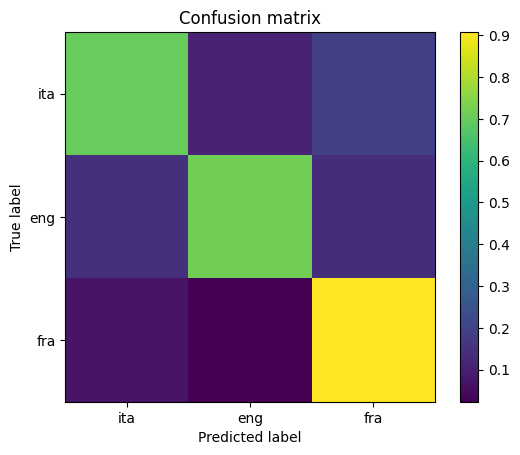

In [49]:
print("evaluating accuracy of quantized model on test set: unheard speakers")
# evaluate validation set with post training quantized model
tflite_model_evaluation(x_test = x_test_unheard, y_onehot_test = y_onehot_test_unheard)

print("")

print("evaluating accuracy of quantized model on test set: known speakers with noisy audio recordings")
# evaluate validation set with post training quantized model
tflite_model_evaluation(x_test = x_test_known, y_onehot_test = y_onehot_test_known)